In [2]:
import numpy as np
import cv2
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

In [1]:
def get_patches1(image, breast_mask, patch_size=224, stride=112):
    patches, breast_mask_patches, locations = [], [], []
    img_height, img_width = image.shape[:2]

    # Calculate the number of patches in each dimension
    num_patches_x = (img_width - patch_size) // stride + 1
    num_patches_y = (img_height - patch_size) // stride + 1

    # Pad the image if necessary
    pad_x = (num_patches_x + 1) * stride + patch_size - img_width
    pad_y = (num_patches_y + 1) * stride + patch_size - img_height

    if pad_x > 0 or pad_y > 0:
        image = cv2.copyMakeBorder(image, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
        breast_mask = cv2.copyMakeBorder(breast_mask, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)

    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            breast_mask_patch = breast_mask[y:y+patch_size, x:x+patch_size]
            if np.sum(breast_mask_patch) > thd:
                img_patch = image[y:y+patch_size, x:x+patch_size]
                patches.append(img_patch)
                locations.append([y, y+patch_size, x, x+patch_size])
                breast_mask_patches.append(breast_mask_patch)

    return patches, breast_mask_patches, locations

In [5]:
def get_patches(contrast, non_contrast, mask, thd, patch_size=224, stride=112):
    
    mask[mask>=1]=1      
    contrast_patches, non_contrast_patches, mask_patches, locations = [], [], [], []
    img_height, img_width = contrast.shape

    # Calculate the number of patches in each dimension
    num_patches_x = (img_width - patch_size) // stride + 1
    num_patches_y = (img_height - patch_size) // stride + 1

    # Pad the image if necessary
    pad_x = (num_patches_x + 1) * stride + patch_size - img_width
    pad_y = (num_patches_y + 1) * stride + patch_size - img_height

    if pad_x > 0 or pad_y > 0:
        contrast = cv2.copyMakeBorder(contrast, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
        non_contrast = cv2.copyMakeBorder(non_contrast, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
        mask = cv2.copyMakeBorder(mask, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
    
    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            if np.sum(mask_patch) > thd:
                contrast_patch = contrast[y:y+patch_size, x:x+patch_size]
                contrast_patches.append(contrast_patch)
                non_contrast_patch = non_contrast[y:y+patch_size, x:x+patch_size]
                non_contrast_patches.append(non_contrast_patch)
                locations.append([y, y+patch_size, x, x+patch_size])
                mask_patches.append(mask_patch)

    return  contrast_patches, non_contrast_patches, mask_patches, locations

In [99]:
image_path = r'C:\Users\qzhuang4\Desktop\Orca2d New\image\tev3p2\ARTERIAL\25.nii'
image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path.replace('image','label')))
patches, mask_patches, locations = get_patches(image, mask, thd, patch_size=128, stride=64)

8

In [30]:
spacing = []
for pat in os.listdir(r'C:\Users\qzhuang4\Desktop\OrcaScore Dataset\OrCa\contrast'):
    img = sitk.ReadImage(os.path.join(r'C:\Users\qzhuang4\Desktop\OrcaScore Dataset\OrCa\contrast',pat))
    spacing.append(img.GetSpacing()[-1])
    array = sitk.GetArrayFromImage(img)
    dimension.append(array.shape[0])

print(set(spacing))
print(set(dimension))
print(min(dimension))
print(max(dimension))

{0.625, 0.25, 0.4000239968299866, 0.44999998807907104, 0.40000200271606445, 0.39999398589134216}
{640, 512, 271, 276, 277, 278, 279, 280, 281, 287, 36, 294, 39, 167, 41, 42, 43, 297, 296, 46, 47, 48, 560, 302, 54, 311, 56, 182, 314, 187, 185, 190, 319, 64, 318, 325, 201, 203, 331, 333, 332, 212, 343, 218, 348, 223, 224, 480, 351, 228, 361, 363, 235, 241, 243, 245, 380, 254}
36
640


In [31]:
def global_standardize_array(arr):
    global_mean = np.mean(arr)
    global_std = np.std(arr)
    standardized_arr = (arr - global_mean) / global_std
    return standardized_arr
 
# Example usage
arr = np.array([[1, 2], [3, 4]])
standardized_arr = global_standardize_array(arr)
print(standardized_arr)

[[-1.34164079 -0.4472136 ]
 [ 0.4472136   1.34164079]]


In [14]:
root =r'C:\Users\qzhuang4\Desktop\Orca2d New\image'
thd = 128 * 128 * 0.25 
for root, dirs, files in os.walk(root):
    for file in files:
        path = os.path.join(root,file)
        if 'ARTERIAL' in path:
            contrast = sitk.GetArrayFromImage(sitk.ReadImage(path))
            non_contrast = sitk.GetArrayFromImage(sitk.ReadImage(path.replace('ARTERIAL','NATIVE'))) 
            mask = sitk.GetArrayFromImage(sitk.ReadImage(path.replace('image','label')))
            contrast_patches, non_contrast_patches, mask_patches, locations = get_patches(contrast,non_contrast,mask,thd, patch_size=256, stride=64)  
            assert len(contrast_patches) == len(non_contrast_patches)
            count = 0     
            for patch in contrast_patches:
                patch = global_standardize_array(patch)
            #     patch_img = sitk.GetImageFromArray(patch)
            #     out_dir = root.replace('image','image patch 256')
            #     if not os.path.exists(out_dir):
            #         os.makedirs(out_dir)
            #     out_path = os.path.join(out_dir,file.split('.')[0]+'_'+'patch'+str(count) + ".nii")
            #     sitk.WriteImage(patch_img,out_path)
            #     count += 1
            # count = 0
            # for patch in non_contrast_patches:
            #     patch = 
            #     patch_img = sitk.GetImageFromArray(patch)
            #     out_dir = root.replace('image','image patch 256').replace('ARTERIAL','NATIVE')
            #     if not os.path.exists(out_dir):
            #         os.makedirs(out_dir)
            #     out_path = os.path.join(out_dir,file.split('.')[0]+'_'+'patch'+str(count) + ".nii")
            #     sitk.WriteImage(patch_img,out_path)
            #     count += 1

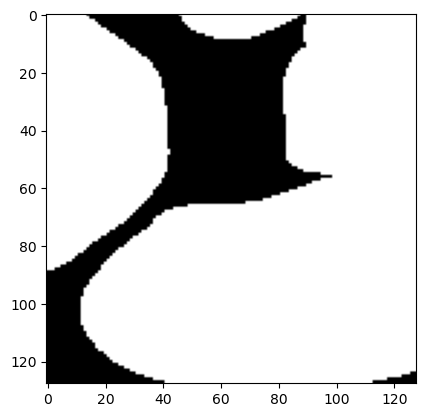

In [95]:
plt.imshow(mask_patches[19],cmap='gray')

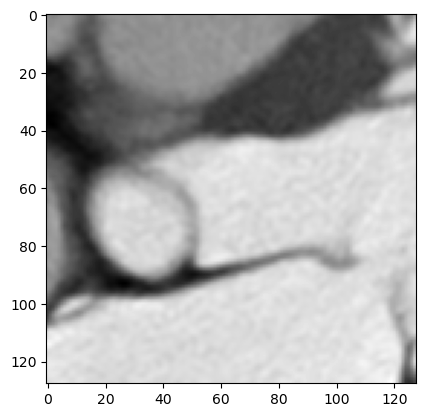

In [98]:
plt.imshow(patches[13],cmap='gray')